In [1]:
# Clone the repository
%cd /content
!git clone https://github.com/materialstheory/ml-analytic-continuation.git
#!git pull


/content
Cloning into 'ml-analytic-continuation'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 138 (delta 8), reused 16 (delta 6), pack-reused 117
Receiving objects: 100% (138/138), 248.79 MiB | 8.53 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [6]:
# CD into the repository directory.
%cd /content/ml-analytic-continuation/model


/content/ml-analytic-continuation/model


In [7]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from models_multiple_srun import create_model, A2G, custom_loss_function, custom_metric_function

BETA = 40 # default inverse temperature
SUM2INT = 799/16 # different normalization

bound = lambda std: 10*std # define upper bound for uncertainty

def predict(Gl_, model_, beta, sample = 100):
    """
    inputs: Legendre coefficients of imag. time GF, model, number of samples used for uncertainty estimation
    return mean and standard deviation
    """
    A_ = np.zeros((sample,800))
    for i in range(sample):
        A_[i,:] = model_(tf.constant(Gl_.reshape(1, 80)*BETA/beta, dtype='float32'), training = True).numpy()[0,:]

    A_avg = model_(tf.constant(Gl_.reshape(1, 80)*BETA/beta, dtype='float32'), training = False).numpy()[0,:]    
    A_std = np.std(A_, axis = 0)

    return A_avg, A_std

def view(A_avg_, A_std_, beta, omega = np.linspace(-8, 8, 800)):
  """
  inputs: mean A, standard deviation of A, beta, omega*
  plot
  """
  plt.plot(omega*BETA/beta, A_avg_*SUM2INT*beta/BETA, label = "mean")
  plt.errorbar(x = omega*BETA/beta, y = A_avg_*SUM2INT*beta/BETA, yerr = bound(A_std_*SUM2INT)*beta/BETA, alpha=0.3, label = "uncertainty")
  plt.xlabel(r"$\omega$")
  plt.ylabel(r"$A(\omega)$")
  plt.legend()
  plt.title(r"$\beta = $" + str(beta))

  plt.savefig("A_omega.pdf", dpi = 300)
  


# **Load models**
* "recp1" labels the training set similar to the Arsenault (2019) paper, which works well for spectral functions similar to maximum entropy solutions.
* "recp2" labels the "hard" training set contains sharp peaks at high energies. Not recommended for practical usage, unless there is a reason for it.


In [10]:

models_dict = {"recp1":{1: None, 2: None, 3: None},
               "recp2":{1: None, 2: None, 3: None}}

models_dict["recp1"][1] = create_model(1e-4, 100)
models_dict["recp1"][1].load_weights('cp_recp1_mult5-res2222_100-n4_best') # noise level 1e-4

models_dict["recp1"][2] = create_model(1e-3, 100)
models_dict["recp1"][2].load_weights('cp_recp1_mult5-res2222_100-n3_best') # noise level 1e-3

models_dict["recp1"][3] = create_model(1e-2, 100)
models_dict["recp1"][3].load_weights('cp_recp1_mult5-res2222_100-n2_best') # noise level 1e-2

models_dict["recp2"][1] = create_model(1e-4, 100)
models_dict["recp2"][1].load_weights('cp_recp2_mult5-res2222_100-n4_best')

models_dict["recp2"][2] = create_model(1e-3, 100)
models_dict["recp2"][2].load_weights('cp_recp2_mult5-res2222_100-n3_best')

models_dict["recp2"][3] = create_model(1e-2, 100)
models_dict["recp2"][3].load_weights('cp_recp2_mult5-res2222_100-n2_best')

# **Data requirement**

* Definitions:
 * beta: inverse temperature in eV
 * expected_frequency_range (in eV): beyond which the spectral functions are expected to be zero.

* beta * expected_frequency_range <= 40 * 16

 * predictions for beta < 20 are not verified

* 80 Legendre coefficients of imaginary time Green's function
 * for measurements with less Legendre coefficients, pad the higher order terms with zeros.

# **How to upload data**
* Click on "files" at the left panel, then you will see a file tree showing the git repo analytic_continuation under /content
* Click on "Upload to session storage", then choose your data file

## Example 1
Realistic QMC for cubic SVO at $\beta = 20$ with NN1 and NN2 trained at $\sigma = 10^{-3}$.

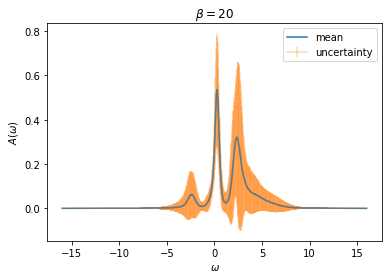

In [12]:
# replace with your Legendre coeffcients of imag time GF, and set the inverse temperature
beta = 20
Gl_test = np.zeros(80)
Gl_test[:50] = np.real(np.load("../test-data/SVO_beta20.npy")[:,0,0])

A_predict, A_std = predict(Gl_test, models_dict["recp1"][2].get_layer('G2A'), beta, 100)

view(A_predict, A_std, beta)
plt.show()

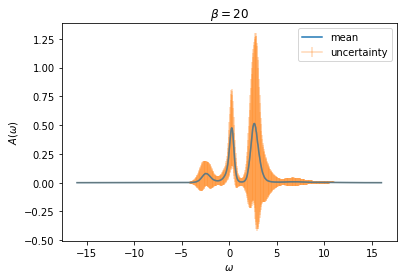

In [13]:
# replace with your Legendre coeffcients of imag time GF, and set the inverse temperature
beta = 20
Gl_test = np.zeros(80)
Gl_test[:50] = np.real(np.load("../test-data/SVO_beta20.npy")[:,0,0])

A_predict, A_std = predict(Gl_test, models_dict["recp2"][2].get_layer('G2A'), beta, 100)

view(A_predict, A_std, beta)
plt.show()

## Example 2
special function given by
$A(\omega) = \frac{1}{\sigma\sqrt{2\pi}}\exp{(-\frac{1}{2}(\frac{(\sinh(\omega + 1) - 2)\times 0.6}{\sigma})^{2})}$
reconstructed by NN1 and NN2 at the correct noise level.

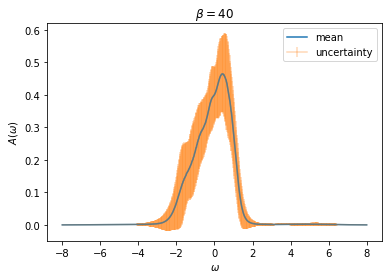

In [14]:
A_omega_test = np.load("../test-data/A_omega_test.npy") # test spectral functions

# replace with your Legendre coeffcients of imag time GF, and set the inverse temperature
beta = 40
Gl_test = np.random.normal(A2G(tf.constant(A_omega_test.astype('float32'))).numpy()/SUM2INT, 1e-3)[7,:]


A_predict, A_std = predict(Gl_test, models_dict["recp1"][2].get_layer('G2A'), beta, 100)

view(A_predict, A_std, beta)
plt.show()

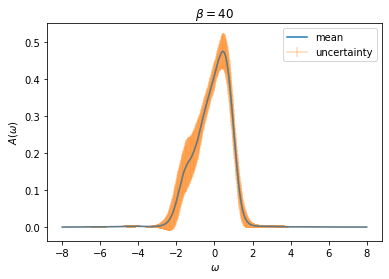

In [15]:
A_omega_test = np.load("../test-data/A_omega_test.npy") # test spectral functions

# replace with your Legendre coeffcients of imag time GF, and set the inverse temperature
beta = 40
Gl_test = np.random.normal(A2G(tf.constant(A_omega_test.astype('float32'))).numpy()/SUM2INT, 1e-3)[7,:]


A_predict, A_std = predict(Gl_test, models_dict["recp2"][2].get_layer('G2A'), beta, 100)

view(A_predict, A_std, beta)
plt.show()

## Example 3 a:
Lorentzian peak $\gamma = 1$

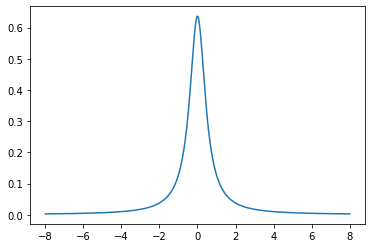

In [16]:
omega = np.linspace(-8, 8, 800)
lorentzian = lambda x0, gamma: 1/np.pi * 0.5*gamma/((omega- x0)**2 + (0.5*gamma)**2)
L1 =  lorentzian(0, 1)
plt.plot(omega, L1)


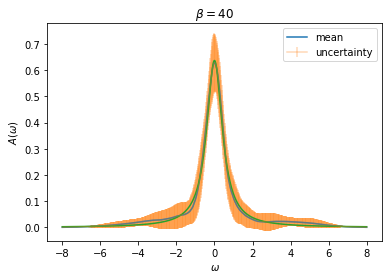

In [17]:
A_omega_test = L1.reshape(1, 800) # test spectral functions

# replace with your Legendre coeffcients of imag time GF, and set the inverse temperature
beta = 40
Gl_test = np.random.normal(A2G(tf.constant(A_omega_test.astype('float32'))).numpy()/SUM2INT, 1e-2)[0,:]


A_predict, A_std = predict(Gl_test, models_dict["recp1"][3].get_layer('G2A'), beta, 100)

view(A_predict, A_std, beta)
plt.plot(omega, L1)
plt.show()

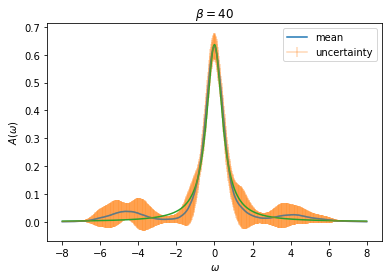

In [18]:
A_omega_test = L1.reshape(1, 800) # test spectral functions

# replace with your Legendre coeffcients of imag time GF, and set the inverse temperature
beta = 40
Gl_test = np.random.normal(A2G(tf.constant(A_omega_test.astype('float32'))).numpy()/SUM2INT, 1e-2)[0,:]


A_predict, A_std = predict(Gl_test, models_dict["recp2"][3].get_layer('G2A'), beta, 100)

view(A_predict, A_std, beta)
plt.plot(omega, L1)
plt.show()

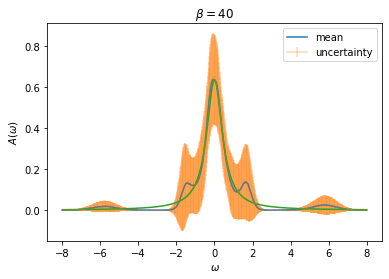

In [19]:

A_omega_test = L1.reshape(1, 800) # test spectral functions

# replace with your Legendre coeffcients of imag time GF, and set the inverse temperature
beta = 40
Gl_test = np.random.normal(A2G(tf.constant(A_omega_test.astype('float32'))).numpy()/SUM2INT, 1e-3)[0,:]


A_predict, A_std = predict(Gl_test, models_dict["recp1"][2].get_layer('G2A'), beta, 100)

view(A_predict, A_std, beta)
plt.plot(omega, L1)
plt.show()

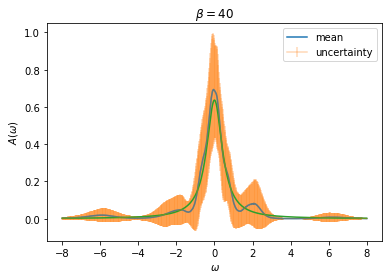

In [20]:
A_omega_test = L1.reshape(1, 800) # test spectral functions

# replace with your Legendre coeffcients of imag time GF, and set the inverse temperature
beta = 40
Gl_test = np.random.normal(A2G(tf.constant(A_omega_test.astype('float32'))).numpy()/SUM2INT, 1e-4)[0,:]


A_predict, A_std = predict(Gl_test, models_dict["recp1"][1].get_layer('G2A'), beta, 100)

view(A_predict, A_std, beta)
plt.plot(omega, L1)
plt.show()

## Example 3 b
Lorentzian peak $\gamma = 0.5$

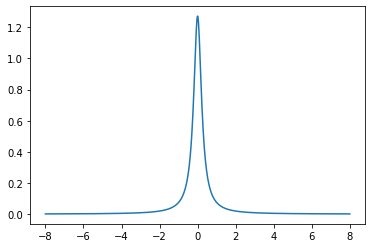

In [21]:
omega = np.linspace(-8, 8, 800)
lorentzian = lambda x0, gamma: 1/np.pi * 0.5*gamma/((omega- x0)**2 + (0.5*gamma)**2)
L1 =  lorentzian(0, 0.5)
plt.plot(omega, L1)

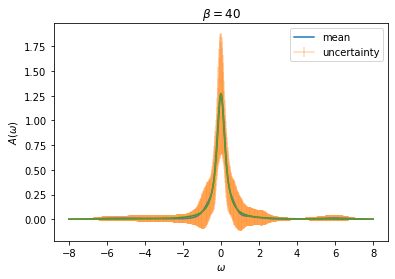

In [22]:
A_omega_test = L1.reshape(1, 800) # test spectral functions

# replace with your Legendre coeffcients of imag time GF, and set the inverse temperature
beta = 40
Gl_test = np.random.normal(A2G(tf.constant(A_omega_test.astype('float32'))).numpy()/SUM2INT, 1e-4)[0,:]


A_predict, A_std = predict(Gl_test, models_dict["recp1"][1].get_layer('G2A'), beta, 100)

view(A_predict, A_std, beta)
plt.plot(omega, L1)
plt.show()

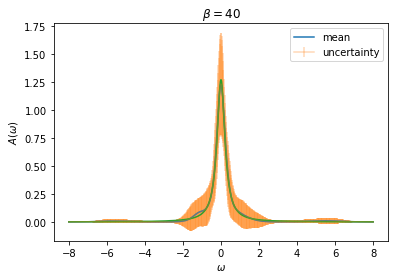

In [23]:
A_omega_test = L1.reshape(1, 800) # test spectral functions

# replace with your Legendre coeffcients of imag time GF, and set the inverse temperature
beta = 40
Gl_test = np.random.normal(A2G(tf.constant(A_omega_test.astype('float32'))).numpy()/SUM2INT, 1e-3)[0,:]


A_predict, A_std = predict(Gl_test, models_dict["recp1"][2].get_layer('G2A'), beta, 100)

view(A_predict, A_std, beta)
plt.plot(omega, L1)
plt.show()

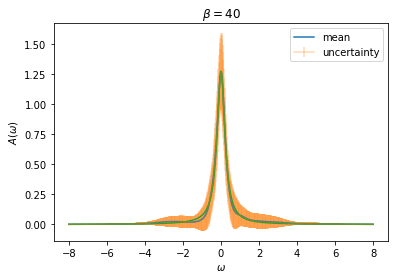

In [24]:
A_omega_test = L1.reshape(1, 800) # test spectral functions

# replace with your Legendre coeffcients of imag time GF, and set the inverse temperature
beta = 40
Gl_test = np.random.normal(A2G(tf.constant(A_omega_test.astype('float32'))).numpy()/SUM2INT, 1e-2)[0,:]


A_predict, A_std = predict(Gl_test, models_dict["recp1"][3].get_layer('G2A'), beta, 100)

view(A_predict, A_std, beta)
plt.plot(omega, L1)
plt.show()

## Example 3 c
Lorentzian peak $\gamma = 1$ shifted by 1

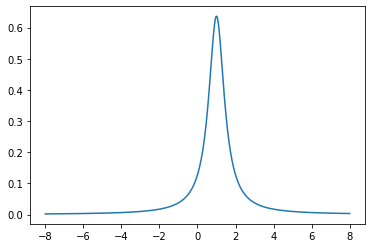

In [25]:
omega = np.linspace(-8, 8, 800)
lorentzian = lambda x0, gamma: 1/np.pi * 0.5*gamma/((omega- x0)**2 + (0.5*gamma)**2)
L1 =  lorentzian(1, 1)
plt.plot(omega, L1)

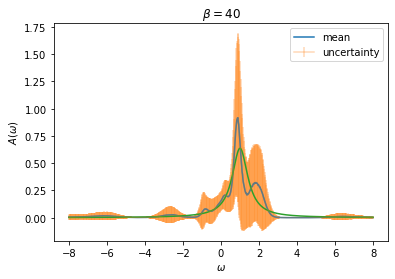

In [26]:
A_omega_test = L1.reshape(1, 800) # test spectral functions

# replace with your Legendre coeffcients of imag time GF, and set the inverse temperature
beta = 40
Gl_test = np.random.normal(A2G(tf.constant(A_omega_test.astype('float32'))).numpy()/SUM2INT, 1e-4)[0,:]


A_predict, A_std = predict(Gl_test, models_dict["recp1"][1].get_layer('G2A'), beta, 100)

view(A_predict, A_std, beta)
plt.plot(omega, L1)
plt.show()

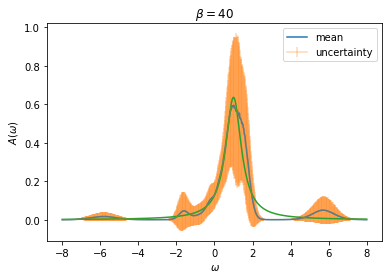

In [27]:
A_omega_test = L1.reshape(1, 800) # test spectral functions

# replace with your Legendre coeffcients of imag time GF, and set the inverse temperature
beta = 40
Gl_test = np.random.normal(A2G(tf.constant(A_omega_test.astype('float32'))).numpy()/SUM2INT, 1e-3)[0,:]


A_predict, A_std = predict(Gl_test, models_dict["recp1"][2].get_layer('G2A'), beta, 100)

view(A_predict, A_std, beta)
plt.plot(omega, L1)
plt.show()

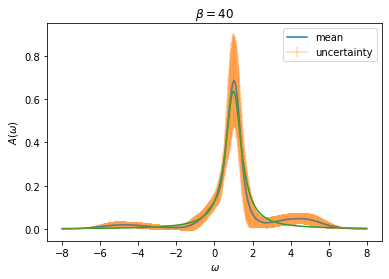

In [28]:
A_omega_test = L1.reshape(1, 800) # test spectral functions

# replace with your Legendre coeffcients of imag time GF, and set the inverse temperature
beta = 40
Gl_test = np.random.normal(A2G(tf.constant(A_omega_test.astype('float32'))).numpy()/SUM2INT, 1e-2)[0,:]


A_predict, A_std = predict(Gl_test, models_dict["recp1"][3].get_layer('G2A'), beta, 100)

view(A_predict, A_std, beta)
plt.plot(omega, L1)
plt.show()

## Example 3 d
Lorentzian peak $\gamma = 2$ shifted by 1.5, which is not expected to work.

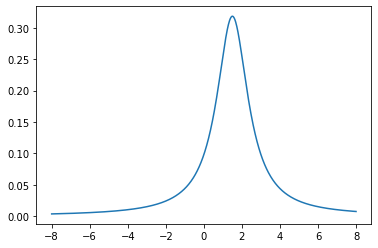

In [29]:
omega = np.linspace(-8, 8, 800)
lorentzian = lambda x0, gamma: 1/np.pi * 0.5*gamma/((omega- x0)**2 + (0.5*gamma)**2)
L1 =  lorentzian(1.5, 2)
plt.plot(omega, L1)

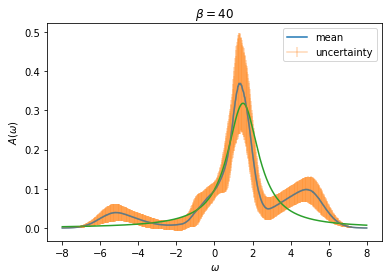

In [30]:
A_omega_test = L1.reshape(1, 800) # test spectral functions

# replace with your Legendre coeffcients of imag time GF, and set the inverse temperature
beta = 40
Gl_test = np.random.normal(A2G(tf.constant(A_omega_test.astype('float32'))).numpy()/SUM2INT, 1e-2)[0,:]


A_predict, A_std = predict(Gl_test, models_dict["recp1"][3].get_layer('G2A'), beta, 100)

view(A_predict, A_std, beta)
plt.plot(omega, L1)
plt.show()

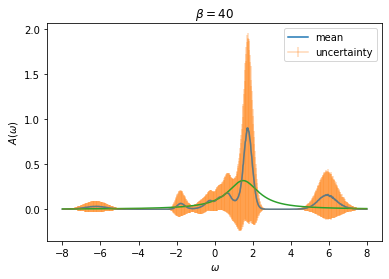

In [31]:
A_omega_test = L1.reshape(1, 800) # test spectral functions

# replace with your Legendre coeffcients of imag time GF, and set the inverse temperature
beta = 40
Gl_test = np.random.normal(A2G(tf.constant(A_omega_test.astype('float32'))).numpy()/SUM2INT, 1e-3)[0,:]


A_predict, A_std = predict(Gl_test, models_dict["recp1"][2].get_layer('G2A'), beta, 100)

view(A_predict, A_std, beta)
plt.plot(omega, L1)
plt.show()

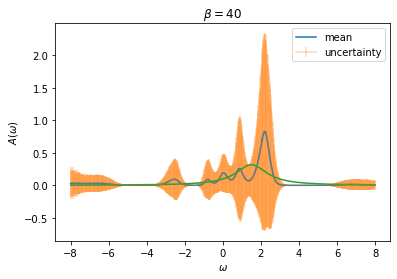

In [32]:
A_omega_test = L1.reshape(1, 800) # test spectral functions

# replace with your Legendre coeffcients of imag time GF, and set the inverse temperature
beta = 40
Gl_test = np.random.normal(A2G(tf.constant(A_omega_test.astype('float32'))).numpy()/SUM2INT, 1e-4)[0,:]


A_predict, A_std = predict(Gl_test, models_dict["recp1"][1].get_layer('G2A'), beta, 100)

view(A_predict, A_std, beta)
plt.plot(omega, L1)
plt.show()